# Download the necessary libraries


**NOTE:**
**So tensorflow *2.15.0* because the version of tensorflow used in collab is *2.18.0* and the *tensorflow.keras.preprocessing* has been deprecated as from *2.16.0* so this was the reason for our choice of tensorflow version.**

In [1]:
!pip install -U nltk
!python -m nltk.downloader all
!pip install -U gensim
!pip install keras
!pip install googletrans
!pip install langdetect
!pip install tensorflow==2.15.0

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]  

In [35]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
import nltk
from langdetect import detect, LangDetectException
from googletrans import Translator
import time
import asyncio
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, AdamW, Adagrad, Adadelta, Adamax
import gensim.downloader as gensim_api
from gensim.models import Word2Vec
import pickle
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


**After scraping amazon reviews using *APIFY*  https://apify.com/ which is the web app design to help fetch the review and metadata of amazon products just using the *PRODUCT URL* the review of this data is fetched and some other information, and one can save it in your choice of file format options given, the reason this was chosen because to web scrape amazon review one has to login due to the *firewall protection* so writing a script would expose one's credentials**.

In [4]:
# Base name for your files
base_name = 'dataset_amazon-sentiment-analysis'

# Create a list of file names
file_list = [f'{base_name}_{i}.csv' for i in range(1, 6)]

# Create an empty list to store DataFrames
df_list = []

# Loop through the file list, read each CSV, and append it to the list
for file in file_list:
    try:
        df = pd.read_csv(file)
        df_list.append(df)
    except FileNotFoundError:
        print(f"File not found: {file}")

# Concatenate the DataFrames in the list
if df_list:  # Check if the list is not empty
    merged_df = pd.concat(df_list, ignore_index=True)
else:
    print("No files were loaded.")

In [5]:
merged_df.shape

(2570, 64)

In [6]:
merged_df.columns

Index(['country', 'countryCode', 'date', 'filterByKeyword', 'filterByRating',
       'input', 'isAmazonVine', 'isProductPageReviewFromOtherCountry',
       'isVerified', 'position', 'product/listPrice', 'product/price',
       'productAsin', 'productOriginalAsin', 'ratingScore',
       'reviewCategoryUrl', 'reviewDescription', 'reviewId', 'reviewImages/0',
       'reviewImages/1', 'reviewImages/2', 'reviewImages/3', 'reviewImages/4',
       'reviewImages/5', 'reviewImages/6', 'reviewImages/7', 'reviewImages/8',
       'reviewImages/9', 'reviewImages/10', 'reviewImages/11',
       'reviewImages/12', 'reviewImages/13', 'reviewImages/14',
       'reviewImages/15', 'reviewImages/16', 'reviewImages/17',
       'reviewImages/18', 'reviewImages/19', 'reviewImages/20',
       'reviewImages/21', 'reviewImages/22', 'reviewImages/23',
       'reviewImages/24', 'reviewImages/25', 'reviewImages/26',
       'reviewImages/27', 'reviewImages/28', 'reviewImages/29',
       'reviewReaction', 'reviewTitl

In [7]:
# Select the desired columns
filtered_df = merged_df[['reviewTitle', 'reviewDescription', 'ratingScore']]

# Display the first few rows of the modified DataFrame
filtered_df

,reviewTitle,reviewDescription,ratingScore
0,"Great Summer Tee's, good value, good quality, ...",Having read most of the negative reviews of th...,5
1,These are really soft and approved by the men ...,My husband needed new shirts. His is always ge...,5
2,Order your size…you’ll ACTUALLY get it!!!,Where have these shirts been all of my life! I...,5
3,They are okay. But shrink too much.,"When I first purchased these shirts, they fit ...",4
4,Great summer shirt or under shirt for dress sh...,Great shirts for the price and good summer t s...,5
...,...,...,...
2565,Africa Trail,What a wonderful adventure.This would make a g...,4
2566,Go to Africa!,"I have spent months on the road in Africa, tho...",5
2567,Great game,I love this game. Real life experiences. Great...,5
2568,Not what I expected.,"Not what I thought. It's astrology, not astron...",1


**During and after scraping the reviews I noticed most of amazon product had an average of 4.5 and 5.0 reviews, because most products with average of 1.0, 2.0, 2.5, 3.0, 3.5, the number of reviews with these averages are few which has a tendency of causing class imbalance and my intuition is that if a customer sees a bad review on a product it discourages them to buy the product this is what causes low review frequency on bad reviews. So inorder to reduce class imbalance between 5 classes after thorough overview checking of the these reviews I noticed most 3 stars reviews were off bad sentiments although the rating is a 3 the review is really bad so I decided one of the cells below to join 1, 2, 3 star ratings as bad sentiment and only 4 and above would be considered good sentiment on a product even these 4 start review I noticed most user talk about the little thing they don't like about the product nort eben the good things about it which I feel might give the models hard time in training because it is a good sentiment but the review is a bit on the negative side, so to try reducing the issue in of the cells I decided to join the review description some of them review title was really positive.**

In [8]:
filtered_df['ratingScore'].value_counts()

,count
ratingScore,
5,1706
1,347
4,285
3,143
2,89


In [9]:
filtered_df[filtered_df['ratingScore'] == 4].tail(10)

,reviewTitle,reviewDescription,ratingScore
2517,Older Software,Used on an old Windows XP laptop at the cottag...,4
2519,Husband loves all the variety,There are over 60 games to be played that will...,4
2524,decent for the price,I have played an old version of Hoyle cards fo...,4
2535,Problem solving strategy,This software has been good for kids and also ...,4
2539,great beginner program,Great basic program. I used it to be able to s...,4
2541,nice product but not 5 star,This is a very nice product. Chosing what you...,4
2555,It's OK....Not Totally What I expected,It's OK...but not what I was expecting. I rea...,4
2558,Grandson loved this older CD,Grandson wanted My Ocean Sim for Christmas. He...,4
2561,"A good game, based on the ""Oregon Trail"" game,...",Many games have tried to make variations of ot...,4
2565,Africa Trail,What a wonderful adventure.This would make a g...,4


In [10]:
filtered_df.loc[:, 'review'] = filtered_df['reviewTitle'].astype(str) + ' ' + filtered_df['reviewDescription'].astype(str)

# Create a new DataFrame with only the 'review' and 'ratingScore' columns
# This step is already creating a new DataFrame, so no .loc needed here
review_and_score_df = filtered_df[['review', 'ratingScore']].copy()

# Rename the 'ratingScore' column to 'score' for clarity
review_and_score_df.rename(columns={'ratingScore': 'score'}, inplace=True)

# Display the first few rows of the new DataFrame
review_and_score_df.head()

<ipython-input-10-c5803c84389f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'review'] = filtered_df['reviewTitle'].astype(str) + ' ' + filtered_df['reviewDescription'].astype(str)


,review,score
0,"Great Summer Tee's, good value, good quality, ...",5
1,These are really soft and approved by the men ...,5
2,Order your size…you’ll ACTUALLY get it!!! Wher...,5
3,They are okay. But shrink too much. When I fir...,4
4,Great summer shirt or under shirt for dress sh...,5


In [11]:
review_and_score_df.shape

(2570, 2)

In [12]:
# Create a new column 'sentiment' based on the 'score' column
# Assign 0 for scores 1, 2, and 3 (poor sentiment)
# Assign 1 for scores 4 and 5 (good sentiment)

review_and_score_df['sentiment'] = review_and_score_df['score'].apply(lambda x: 0 if x in [1, 2, 3] else 1)

# Display the first few rows of the DataFrame with the new 'sentiment' column
print(review_and_score_df.head())

# Check the distribution of the new 'sentiment' column
print("\nDistribution of the new 'sentiment' column:")
print(review_and_score_df['sentiment'].value_counts())

                                              review  score  sentiment
0  Great Summer Tee's, good value, good quality, ...      5          1
1  These are really soft and approved by the men ...      5          1
2  Order your size…you’ll ACTUALLY get it!!! Wher...      5          1
3  They are okay. But shrink too much. When I fir...      4          1
4  Great summer shirt or under shirt for dress sh...      5          1

Distribution of the new 'sentiment' column:
sentiment
1    1991
0     579
Name: count, dtype: int64


## Cleaning and Text Pre-Processing

**After cleaning these data into ones with stop words and also without stop words we create a directory for each category and not only that save each observation or review in thier owe file beccause since we have removed punctuation in our preprocessing it is hard to know where a single review ends although we could have just used it directly from thier dataframe but for reuse one has to save them although we consume more space, but it the longrun it is a good trade-off.**

In [13]:
# Initialize the translator
translator = Translator()

# --- Asynchronous Text Cleaning and Translation Function with Retry ---
async def clean_and_translate_text_async(text, remove_stopwords=False, max_retries=5, delay=1):
    """
    Asynchronously cleans text before translation, then translates with retries.
    """
    # 1. Handle empty or non-string input
    if not isinstance(text, str) or not text.strip():
        return ""

    # --- Initial Cleaning (before translation) ---
    cleaned_text_initial = text.lower()
    cleaned_text_initial = cleaned_text_initial.translate(str.maketrans('', '', string.punctuation))
    cleaned_text_initial = re.sub(r'[^a-z\s]', '', cleaned_text_initial)
    cleaned_text_initial = re.sub(r'\s+', ' ', cleaned_text_initial).strip()

    if not cleaned_text_initial:
        return ""

    original_text_for_translation = cleaned_text_initial

    # 2. Detect language and translate to English if not with retry (asynchronous)
    translated_text = ""
    async with Translator() as translator:
        for attempt in range(max_retries):
            try:
                lang = detect(original_text_for_translation)
                if lang != 'en':
                    # Translate to English
                    translation_result = await translator.translate(original_text_for_translation, dest='en')
                    translated_text = translation_result.text
                else:
                    translated_text = original_text_for_translation
                break
            except LangDetectException:
                print(f"Language detection failed for text (after initial cleaning): {original_text_for_translation[:50]}...")
                return ""
            except Exception as e:
                print(f"Translation attempt {attempt + 1}/{max_retries} failed for text: {original_text_for_translation[:50]}... Error: {e}")
                if attempt < max_retries - 1:
                    await asyncio.sleep(delay) # Use asyncio.sleep in async functions
                else:
                    print(f"Max retries reached. Translation failed for text: {original_text_for_translation[:50]}...")
                    return ""

    # --- Further Cleaning (after translation, if successful) ---
    text_for_further_cleaning = translated_text

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = text_for_further_cleaning.split()
        words = [w for w in words if w not in stop_words]
        text_for_further_cleaning = ' '.join(words)

    text_for_further_cleaning = text_for_further_cleaning.strip()

    return text_for_further_cleaning

# Using asyncio.gather() to run translations concurrently
async def translate_dataframe_async(df):
    # Create a list of coroutines
    coroutines_with_stopwords = [
        clean_and_translate_text_async(row['review'], remove_stopwords=False, max_retries=5)
        for index, row in df.iterrows()
    ]
    coroutines_without_stopwords = [
        clean_and_translate_text_async(row['review'], remove_stopwords=True, max_retries=5)
        for index, row in df.iterrows()
    ]

    # Run the coroutines concurrently
    results_with_stopwords = await asyncio.gather(*coroutines_with_stopwords)
    results_without_stopwords = await asyncio.gather(*coroutines_without_stopwords)

    # Assign results back to the DataFrame (or a new DataFrame)
    df['cleaned_review_translated_with_stopwords'] = results_with_stopwords
    df['cleaned_review_translated_without_stopwords'] = results_without_stopwords

    return df

# Run the async translation process
translated_df = await translate_dataframe_async(review_and_score_df.copy())

rows_to_drop = translated_df[
    (translated_df['cleaned_review_translated_with_stopwords'] == '') |
    (translated_df['cleaned_review_translated_without_stopwords'] == '')
].index

translated_df.drop(rows_to_drop, inplace=True)
translated_df.reset_index(drop=True, inplace=True)

# --- Extract Cleaned and Translated Sentences and Labels ---

sentences_translated_with_stopwords = translated_df['cleaned_review_translated_with_stopwords'].tolist()
sentences_translated_without_stopwords = translated_df['cleaned_review_translated_without_stopwords'].tolist()
labels = translated_df['sentiment'].tolist()

# Display and verification
print("First 5 cleaned and translated reviews with stopwords:")
print(sentences_translated_with_stopwords[:5])
print("\nFirst 5 cleaned and translated reviews without stopwords:")
print(sentences_translated_without_stopwords[:5])
print("\nFirst 5 labels:")
print(labels[:5])
print(f"\nShape of DataFrame after dropping rows with translation errors: {review_and_score_df.shape}")
print(f"\nNumber of reviews that became empty after cleaning and translation (with stopwords): {sentences_translated_with_stopwords.count('')}")
print(f"Number of reviews that became empty after cleaning and translation (without stopwords): {sentences_translated_without_stopwords.count('')}")

First 5 cleaned and translated reviews with stopwords:
['great summer tees good value good quality good vendor whats not to like having read most of the negative reviews of these shirts most being the fact that they were made of very thin material i decided to try them anyway because summer shirts need to be light weight i did take into account that the shirts are all to cotton and ordered one size larger for shrinkage i wear a mens large so i ordered and extra large i washed the shirts in warm water and dried in the dryer on low removing them immediately to hangers to prevent wrinkles the shirts did indeed shrink just about size but i expect that they will shrink a little more over time so they should fit perfect after one more washing they seem well made with all seams intact and no loose threads the black didnt fade like some reviews said and they shrank more in length than in width but the shirts have extra long tails so that isnt an issue for me over all this bundle of shirts is a

In [14]:
import os
# Define base directories for saving files
base_output_dir = 'cleaned_reviews_dataset'
stopwords_included_dir = os.path.join(base_output_dir, 'with_stopwords')
stopwords_excluded_dir = os.path.join(base_output_dir, 'without_stopwords')
labels_dir = os.path.join(base_output_dir, 'labels')

# Create directories if they don't exist
os.makedirs(stopwords_included_dir, exist_ok=True)
os.makedirs(stopwords_excluded_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Save each observation into a separate file
for i in range(len(sentences_translated_with_stopwords)):
    # Generate unique filename based on index
    filename = f'review_{i}.txt'
    label_filename = f'label_{i}.txt'

    # Save review with stopwords
    filepath_with_stopwords = os.path.join(stopwords_included_dir, filename)
    with open(filepath_with_stopwords, 'w', encoding='utf-8') as f:
        f.write(sentences_translated_with_stopwords[i])

    # Save review without stopwords
    filepath_without_stopwords = os.path.join(stopwords_excluded_dir, filename)
    with open(filepath_without_stopwords, 'w', encoding='utf-8') as f:
        f.write(sentences_translated_without_stopwords[i])

    # Save label
    filepath_label = os.path.join(labels_dir, label_filename)
    with open(filepath_label, 'w', encoding='utf-8') as f:
        f.write(str(labels[i])) # Convert label (integer) to string

print(f"Saved {len(sentences_translated_with_stopwords)} reviews and labels to individual files in '{base_output_dir}'")

Saved 2525 reviews and labels to individual files in 'cleaned_reviews_dataset'


In [15]:
# Define base directories where files are saved
base_output_dir = 'cleaned_reviews_dataset'
stopwords_included_dir = os.path.join(base_output_dir, 'with_stopwords')
stopwords_excluded_dir = os.path.join(base_output_dir, 'without_stopwords')
labels_dir = os.path.join(base_output_dir, 'labels')

# Lists to store the read data
loaded_sentences_with_stopwords = []
loaded_sentences_without_stopwords = []
loaded_labels = []

# Get list of files in the 'with_stopwords' directory (assuming consistent naming)
file_list = os.listdir(stopwords_included_dir)
file_list.sort(key=lambda x: int(x.split('_')[1].split('.')[0])) # Sort by the index in the filename

# Read each file and load the content
for filename in file_list:
    if filename.endswith('.txt'):
        # Extract the index from the filename
        try:
            index = int(filename.split('_')[1].split('.')[0])

            # Read review with stopwords
            filepath_with_stopwords = os.path.join(stopwords_included_dir, filename)
            with open(filepath_with_stopwords, 'r', encoding='utf-8') as f:
                loaded_sentences_with_stopwords.append(f.read())

            # Read review without stopwords (assuming same filename for corresponding review)
            filepath_without_stopwords = os.path.join(stopwords_excluded_dir, filename)
            with open(filepath_without_stopwords, 'r', encoding='utf-8') as f:
                loaded_sentences_without_stopwords.append(f.read())

            # Read label (assuming corresponding label file exists with same index)
            label_filename = f'label_{index}.txt'
            filepath_label = os.path.join(labels_dir, label_filename)
            with open(filepath_label, 'r', encoding='utf-8') as f:
                loaded_labels.append(int(f.read())) # Convert label back to integer

        except (ValueError, FileNotFoundError) as e:
            print(f"Skipping file {filename} due to error: {e}")


# Display the first few loaded elements to verify
print("First 5 loaded reviews with stopwords:")
print(loaded_sentences_with_stopwords[:5])
print("\nFirst 5 loaded reviews without stopwords:")
print(loaded_sentences_without_stopwords[:5])
print("\nFirst 5 loaded labels:")
print(loaded_labels[:5])

# You can now create a new DataFrame from the loaded lists if needed
loaded_df = pd.DataFrame({
    'cleaned_review_translated_with_stopwords': loaded_sentences_with_stopwords,
    'cleaned_review_translated_without_stopwords': loaded_sentences_without_stopwords,
    'sentiment': loaded_labels
})

print("\nShape of the loaded DataFrame:")
print(loaded_df.shape)

First 5 loaded reviews with stopwords:
['great summer tees good value good quality good vendor whats not to like having read most of the negative reviews of these shirts most being the fact that they were made of very thin material i decided to try them anyway because summer shirts need to be light weight i did take into account that the shirts are all to cotton and ordered one size larger for shrinkage i wear a mens large so i ordered and extra large i washed the shirts in warm water and dried in the dryer on low removing them immediately to hangers to prevent wrinkles the shirts did indeed shrink just about size but i expect that they will shrink a little more over time so they should fit perfect after one more washing they seem well made with all seams intact and no loose threads the black didnt fade like some reviews said and they shrank more in length than in width but the shirts have extra long tails so that isnt an issue for me over all this bundle of shirts is a great deal qual

In [16]:
loaded_df['sentiment'].value_counts()

,count
sentiment,
1,1956
0,569


In [17]:
sentences_translated_with_stopwords = loaded_df['cleaned_review_translated_with_stopwords'].tolist()
sentences_translated_without_stopwords = loaded_df['cleaned_review_translated_without_stopwords'].tolist()
labels = loaded_df['sentiment'].tolist()


# --- Word Tokenization (into lists) ---

# Tokenize the reviews with stopwords included
tokenized_sentences_with_stopwords = [nltk.word_tokenize(sentence) for sentence in sentences_translated_with_stopwords]

# Tokenize the reviews without stopwords included
tokenized_sentences_without_stopwords = [nltk.word_tokenize(sentence) for sentence in sentences_translated_without_stopwords]

# --- Get Vocabulary and Vocabulary Length ---

# Get the vocabulary (unique words) for reviews with stopwords
all_words_with_stopwords = [word for tokens in tokenized_sentences_with_stopwords for word in tokens]
vocabulary_with_stopwords = set(all_words_with_stopwords)
vocabulary_length_with_stopwords = len(vocabulary_with_stopwords)

# Get the vocabulary (unique words) for reviews without stopwords
all_words_without_stopwords = [word for tokens in tokenized_sentences_without_stopwords for word in tokens]
vocabulary_without_stopwords = set(all_words_without_stopwords)
vocabulary_length_without_stopwords = len(vocabulary_without_stopwords)

# --- Display Results ---

print("First 5 tokenized sentences with stopwords:")
print(tokenized_sentences_with_stopwords[:5])

print("\nFirst 5 tokenized sentences without stopwords:")
print(tokenized_sentences_without_stopwords[:5])

print(f"\nVocabulary length (unique words) with stopwords: {vocabulary_length_with_stopwords}")
print(f"Vocabulary length (unique words) without stopwords: {vocabulary_length_without_stopwords}")

print("\nFirst 10 words in vocabulary with stopwords:")
print(list(vocabulary_with_stopwords)[:10])

print("\nFirst 10 words in vocabulary without stopwords:")
print(list(vocabulary_without_stopwords)[:10])

First 5 tokenized sentences with stopwords:
[['great', 'summer', 'tees', 'good', 'value', 'good', 'quality', 'good', 'vendor', 'whats', 'not', 'to', 'like', 'having', 'read', 'most', 'of', 'the', 'negative', 'reviews', 'of', 'these', 'shirts', 'most', 'being', 'the', 'fact', 'that', 'they', 'were', 'made', 'of', 'very', 'thin', 'material', 'i', 'decided', 'to', 'try', 'them', 'anyway', 'because', 'summer', 'shirts', 'need', 'to', 'be', 'light', 'weight', 'i', 'did', 'take', 'into', 'account', 'that', 'the', 'shirts', 'are', 'all', 'to', 'cotton', 'and', 'ordered', 'one', 'size', 'larger', 'for', 'shrinkage', 'i', 'wear', 'a', 'mens', 'large', 'so', 'i', 'ordered', 'and', 'extra', 'large', 'i', 'washed', 'the', 'shirts', 'in', 'warm', 'water', 'and', 'dried', 'in', 'the', 'dryer', 'on', 'low', 'removing', 'them', 'immediately', 'to', 'hangers', 'to', 'prevent', 'wrinkles', 'the', 'shirts', 'did', 'indeed', 'shrink', 'just', 'about', 'size', 'but', 'i', 'expect', 'that', 'they', 'will', 

In [18]:
# Verify the DataFrame
print("First 5 rows of loaded DataFrame:")
print(loaded_df.head())
print("\nShape of loaded DataFrame:", loaded_df.shape)

# Prepare features (X) and labels (y)
X_with_stopwords = loaded_df['cleaned_review_translated_with_stopwords']
X_without_stopwords = loaded_df['cleaned_review_translated_without_stopwords']
y = loaded_df['sentiment']

First 5 rows of loaded DataFrame:
            cleaned_review_translated_with_stopwords  \
0  great summer tees good value good quality good...   
1  these are really soft and approved by the men ...   
2  order your sizeyoull actually get it where hav...   
3  they are okay but shrink too much when i first...   
4  great summer shirt or under shirt for dress sh...   

         cleaned_review_translated_without_stopwords  sentiment  
0  great summer tees good value good quality good...          1  
1  really soft approved men house husband needed ...          1  
2  order sizeyoull actually get shirts life pound...          1  
3  okay shrink much first purchased shirts fit pe...          1  
4  great summer shirt shirt dress shirts great sh...          1  

Shape of loaded DataFrame: (2525, 3)


In [19]:
# 2. Split the data into training and testing sets (80% train, 20% test)
X_train_with, X_test_with, y_train, y_test = train_test_split(
    X_with_stopwords, y, test_size=0.2, random_state=42, stratify=y
)
X_train_without, X_test_without, y_train, y_test = train_test_split(
    X_without_stopwords, y, test_size=0.2, random_state=42, stratify=y
)

In [69]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 3)
)

# Fit and transform the training data (with stopwords)
X_train_with_tfidf = tfidf_vectorizer.fit_transform(X_train_with)
X_test_with_tfidf = tfidf_vectorizer.transform(X_test_with)


--- Model Performance (With Stopwords) ---
Accuracy: 0.8613861386138614

Classification Report:
              precision    recall  f1-score   support

         Bad       0.82      0.49      0.62       114
        Good       0.87      0.97      0.92       391

    accuracy                           0.86       505
   macro avg       0.85      0.73      0.77       505
weighted avg       0.86      0.86      0.85       505



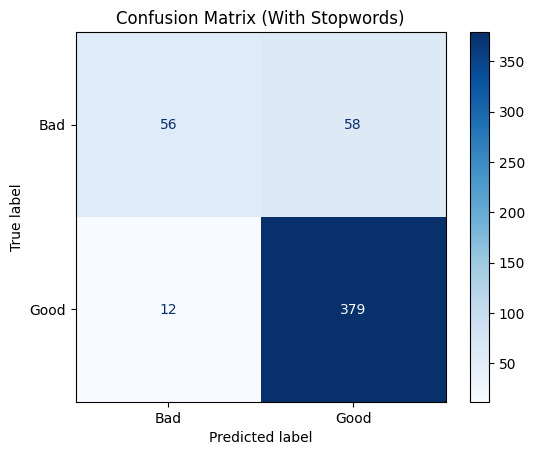

In [71]:
# Train a Logistic Regression model
# Model for data with stopwords
model_with_stopwords = LogisticRegression(max_iter=1000, random_state=42)
model_with_stopwords.fit(X_train_with_tfidf, y_train)
y_pred_with = model_with_stopwords.predict(X_test_with_tfidf)

# Evaluate the models
print("\n--- Model Performance (With Stopwords) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_with))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_with, target_names=['Bad', 'Good']))

# --- Visualize the Confusion Matrix ---

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_with)

# Create a ConfusionMatrixDisplay object
# display_labels are the labels you want to show on the plot (e.g., your class names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])

# Plot the confusion matrix
# You can customize the appearance with parameters like cmap (colormap)
# include_values=True is the default, showing the counts in each cell [2]
disp.plot(cmap=plt.cm.Blues, values_format='d') # Use 'd' to display integers

# Add title
plt.title('Confusion Matrix (With Stopwords)')

# Show the plot
plt.show()

In [84]:
# Fit and transform the training data (without stopwords)
tfidf_vectorizer_without = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 3)
)
X_train_without_tfidf = tfidf_vectorizer_without.fit_transform(X_train_without)
X_test_without_tfidf = tfidf_vectorizer_without.transform(X_test_without)


--- Model Performance (Without Stopwords) ---
Accuracy: 0.8633663366336634

Classification Report:
              precision    recall  f1-score   support

         Bad       0.84      0.49      0.62       114
        Good       0.87      0.97      0.92       391

    accuracy                           0.86       505
   macro avg       0.85      0.73      0.77       505
weighted avg       0.86      0.86      0.85       505



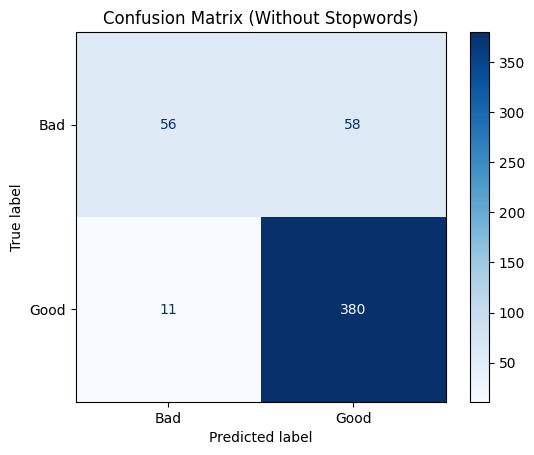

In [85]:
# 5. Make predictions
# Model for data without stopwords
model_without_stopwords = LogisticRegression(max_iter=1000, random_state=42)
model_without_stopwords.fit(X_train_without_tfidf, y_train)
y_pred_without = model_without_stopwords.predict(X_test_without_tfidf)

print("\n--- Model Performance (Without Stopwords) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_without))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_without, target_names=['Bad', 'Good']))

# --- Visualize the Confusion Matrix ---

# Calculate the confusion matrix
cm_without = confusion_matrix(y_test, y_pred_without)

# Create a ConfusionMatrixDisplay object
# display_labels are the labels you want to show on the plot (e.g., your class names)
disp_without = ConfusionMatrixDisplay(confusion_matrix=cm_without, display_labels=['Bad', 'Good'])

# Plot the confusion matrix
# You can customize the appearance with parameters like cmap (colormap)
# include_values=True is the default, showing the counts in each cell [2]
disp_without.plot(cmap=plt.cm.Blues, values_format='d') # Use 'd' to display integers

# Add title
plt.title('Confusion Matrix (Without Stopwords)')

# Show the plot
plt.show()

In [24]:
# 7. Optional: Feature Importance (Top TF-IDF features)
# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients from the model (with stopwords)
coef = model_with_stopwords.coef_[0]
top_positive_indices = np.argsort(coef)[-10:]  # Top 10 positive features
top_negative_indices = np.argsort(coef)[:10]   # Top 10 negative features

print("\n--- Top 10 Features for Positive Sentiment (With Stopwords) ---")
for idx in top_positive_indices:
    print(f"{feature_names[idx]}: {coef[idx]:.4f}")

print("\n--- Top 10 Features for Negative Sentiment (With Stopwords) ---")
for idx in top_negative_indices:
    print(f"{feature_names[idx]}: {coef[idx]:.4f}")


--- Top 10 Features for Positive Sentiment (With Stopwords) ---
easy to: 1.4997
excellent: 1.5736
my: 1.5793
best: 1.6133
perfect: 1.6510
love: 2.1327
easy: 2.1578
and: 2.3102
good: 2.5790
great: 3.4156

--- Top 10 Features for Negative Sentiment (With Stopwords) ---
not: -5.2110
money: -1.9218
waste: -1.9079
dont: -1.8647
cant: -1.8579
computer: -1.8219
disappointed: -1.7817
work: -1.5418
refund: -1.5330
cannot: -1.4309


**In conclusion both the models i.e. one suing stop words and the other not using stop words are not to different from each other i.e. thier differences is just small in from the experiments done but the model that used stop words overall showed more performance to the model that had no stop words in it**

#**KERAS TOKENIZER AND WORD EMBEDDING**

In [25]:
print("First 5 rows of loaded DataFrame:")
print(loaded_df.head())

# Tokenization with TensorFlow.Keras Tokenizer ---
max_words = 5000  # Maximum vocabulary size, can change based on choice
max_len = 100     # Maximum sequence length (adjust based on review length)

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(loaded_df['cleaned_review_translated_with_stopwords'])
sequences = tokenizer.texts_to_sequences(loaded_df['cleaned_review_translated_with_stopwords'])
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare labels
y = loaded_df['sentiment'].values

# Save tokenizer for later use
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenization complete! Sequences shape:", X.shape)

First 5 rows of loaded DataFrame:
            cleaned_review_translated_with_stopwords  \
0  great summer tees good value good quality good...   
1  these are really soft and approved by the men ...   
2  order your sizeyoull actually get it where hav...   
3  they are okay but shrink too much when i first...   
4  great summer shirt or under shirt for dress sh...   

         cleaned_review_translated_without_stopwords  sentiment  
0  great summer tees good value good quality good...          1  
1  really soft approved men house husband needed ...          1  
2  order sizeyoull actually get shirts life pound...          1  
3  okay shrink much first purchased shirts fit pe...          1  
4  great summer shirt shirt dress shirts great sh...          1  
Tokenization complete! Sequences shape: (2525, 100)


In [26]:
# Train Custom TensorFlow.Keras Embedding ---
embedding_dim = 100  # Dimension of embedding vectors

# Split data for training the embedding
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define a simple model to train the embedding
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(input_layer)
# Use GlobalAveragePooling1D to reduce 3D output to 2D
pooled = GlobalAveragePooling1D()(embedding_layer)
dense_layer = Dense(64, activation='relu')(pooled)
dense_layer = Dense(32, activation='relu')(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
]

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy')

# Train the model to learn the embedding
model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

# Extract the trained embedding weights
keras_embedding_weights = model.layers[1].get_weights()[0]

# Prepare for visualization
word_index = tokenizer.word_index
words_to_visualize = 100  # Number of words to visualize
keras_vectors = []
keras_words = []
for word, i in word_index.items():
    if i < max_words and i > 0:  # Skip OOV and ensure within vocab
        keras_vectors.append(keras_embedding_weights[i])
        keras_words.append(word)
        if len(keras_vectors) >= words_to_visualize:
            break
keras_vectors = np.array(keras_vectors)

# Visualize
def plot_embeddings(vectors, labels, title, filename):
    if len(vectors) == 0:
        print(f"No vectors to visualize for {title}")
        return
    tsne = TSNE(n_components=2, random_state=42, perplexity=5 if len(vectors) > 10 else 2)
    vectors_2d = tsne.fit_transform(vectors)
    plt.figure(figsize=(10, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='blue', alpha=0.5)
    for i, word in enumerate(labels):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=9)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(filename)
    plt.close()

plot_embeddings(keras_vectors, keras_words, 'Trained TensorFlow.Keras Embedding', 'keras_embedding_plot.png')
np.save('keras_embedding_weights.npy', keras_embedding_weights)

print("Custom TensorFlow.Keras embedding trained and visualized! Check keras_embedding_plot.png")

Epoch 1/80
64/64 [==============================] - 2s 13ms/step - loss: 0.6819 - val_loss: 0.6685 - lr: 1.0000e-04
Epoch 2/80
64/64 [==============================] - 1s 10ms/step - loss: 0.6529 - val_loss: 0.6342 - lr: 1.0000e-04
Epoch 3/80
64/64 [==============================] - 1s 10ms/step - loss: 0.6139 - val_loss: 0.5921 - lr: 1.0000e-04
Epoch 4/80
64/64 [==============================] - 1s 9ms/step - loss: 0.5690 - val_loss: 0.5526 - lr: 1.0000e-04
Epoch 5/80
64/64 [==============================] - 1s 9ms/step - loss: 0.5388 - val_loss: 0.5347 - lr: 1.0000e-04
Epoch 6/80
64/64 [==============================] - 1s 9ms/step - loss: 0.5251 - val_loss: 0.5267 - lr: 1.0000e-04
Epoch 7/80
64/64 [==============================] - 1s 9ms/step - loss: 0.5168 - val_loss: 0.5202 - lr: 1.0000e-04
Epoch 8/80
64/64 [==============================] - 1s 10ms/step - loss: 0.5095 - val_loss: 0.5137 - lr: 1.0000e-04
Epoch 9/80
64/64 [==============================] - 1s 10ms/step - loss: 0.5

In [27]:
# Train Custom Word2Vec Embedding with Gensim ---
# Convert reviews to list of tokenized words for Word2Vec
tokenized_reviews = [review.split() for review in loaded_df['cleaned_review_translated_with_stopwords']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=embedding_dim, window=5, min_count=5, workers=4, sg=1)

# Prepare for visualization
w2v_vectors = []
w2v_words = []
for word, i in word_index.items():
    if word in word2vec_model.wv and i < max_words:
        w2v_vectors.append(word2vec_model.wv[word])
        w2v_words.append(word)
        if len(w2v_vectors) >= words_to_visualize:
            break
w2v_vectors = np.array(w2v_vectors)

# Visualize and save
plot_embeddings(w2v_vectors, w2v_words, 'Custom Word2Vec Embedding', 'custom_word2vec_plot.png')
word2vec_model.save('custom_word2vec.model')
np.save('custom_word2vec_vectors.npy', w2v_vectors)

print("Custom Word2Vec embedding trained and visualized! Check custom_word2vec_plot.png")

Custom Word2Vec embedding trained and visualized! Check custom_word2vec_plot.png


In [ ]:
# load Pre-Trained Word2Vec Embedding ---
pretrained_word2vec = gensim_api.load('word2vec-google-news-300')
# Project to 100 dimensions for consistency
word2vec_dim = embedding_dim

# Prepare for visualization
pretrained_w2v_vectors = []
pretrained_w2v_words = []
for word, i in word_index.items():
    if word in pretrained_word2vec and i < max_words:
        vector = pretrained_word2vec[word][:embedding_dim]  # Project to 100 dims
        pretrained_w2v_vectors.append(vector)
        pretrained_w2v_words.append(word)
        if len(pretrained_w2v_vectors) >= words_to_visualize:
            break
pretrained_w2v_vectors = np.array(pretrained_w2v_vectors)

# Visualize and save
plot_embeddings(pretrained_w2v_vectors, pretrained_w2v_words, 'Pre-Trained Word2Vec Embedding', 'pretrained_word2vec_plot.png')
np.save('pretrained_word2vec_vectors.npy', pretrained_w2v_vectors)

print("Pre-Trained Word2Vec embedding loaded and visualized! Check pretrained_word2vec_plot.png")

In [28]:
# --- Cell 6: Load Pre-Trained GloVe Embedding ---
glove_path = '/content/glove.6B.100d.txt'  # Download from: https://nlp.stanford.edu/projects/glove/
if not os.path.exists(glove_path):
    print("Please download 'glove.6B.100d.txt' from https://nlp.stanford.edu/projects/glove/")
    print("Place it in the working directory and rerun this cell.")
else:
    glove_embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector

    # Prepare for visualization
    glove_vectors = []
    glove_words = []
    for word, i in word_index.items():
        if word in glove_embeddings and i < max_words:
            glove_vectors.append(glove_embeddings[word])
            glove_words.append(word)
            if len(glove_vectors) >= words_to_visualize:
                break
    glove_vectors = np.array(glove_vectors)

    # Visualize and save
    plot_embeddings(glove_vectors, glove_words, 'Pre-Trained GloVe Embedding', 'glove_plot.png')
    np.save('glove_vectors.npy', glove_vectors)

    print("Pre-Trained GloVe embedding loaded and visualized! Check glove_plot.png")

Pre-Trained GloVe embedding loaded and visualized! Check glove_plot.png


#**LOADING BEST EMBEDDED LAYERS**

**Decided to go with cleanead reviews with stop words from the traditional methods I noticed after using different hyperparameters stop words were really key do help identifying sentiments i.e. some stop words which are negation come before some rare words that would change the context of the sentence for example a user says "I won't buy the product", the removal of the stop word "won't" would change the whole context of this sentence so the model either traditional or deep learning models would see "I buy the product" making it harder if no rare negative words are present in the review so we decided to with cleeaned reviews with stop words, we would in the future try using the other without stop words but for now we want to experiment with this, there are 2 embedding we are not using the one I trained using our review data using *keras* reviewed the *.png* file helping visualizing the relationship between those words and noticed the other embedding classified better, but mind you we haven't tried if it would work better, also the one that downloads *google word2vec* because of download speed so you can eventually experiment with those other 2**

In [29]:
# Load tokenized data and labels
max_words = 5000
max_len = 100
embedding_dim = 100

if 'X' not in globals() or 'y' not in globals():
    if os.path.exists('tokenizer.pickle'):
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)
    else:
        print("Tokenizer not found! Please run previous tokenization code.")
        exit()
    sequences = tokenizer.texts_to_sequences(loaded_df['cleaned_review_translated_with_stopwords'])
    X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    y = loaded_df['sentiment'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load custom Word2Vec embedding matrix
if os.path.exists('custom_word2vec.model'):
    word2vec_model = Word2Vec.load('custom_word2vec.model')
    word_index = tokenizer.word_index
    embedding_matrix_w2v = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words and word in word2vec_model.wv:
            embedding_matrix_w2v[i] = word2vec_model.wv[word]
else:
    print("Custom Word2Vec model not found! Please run previous embedding generation code.")
    embedding_matrix_w2v = np.zeros((max_words, embedding_dim))

# Load GloVe embedding matrix
glove_path = '/content/glove.6B.100d.txt'
if os.path.exists(glove_path):
    glove_embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    embedding_matrix_glove = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words and word in glove_embeddings:
            embedding_matrix_glove[i] = glove_embeddings[word]
else:
    print("GloVe file not found! Please download 'glove.6B.100d.txt' from https://nlp.stanford.edu/projects/glove/")
    embedding_matrix_glove = np.zeros((max_words, embedding_dim))

print("Data and embeddings loaded! X_train shape:", X_train.shape, "Embedding matrices shapes:", embedding_matrix_w2v.shape, embedding_matrix_glove.shape)

Data and embeddings loaded! X_train shape: (2020, 100) Embedding matrices shapes: (5000, 100) (5000, 100)


##**LSTM MODEL CREATION**

In [50]:
def create_lstm_model(embedding_matrix, max_words=5000, max_len=100, embedding_dim=100,
                      lstm_units=64, dense_units=32, trainable_embedding=False):
    """
    Create an LSTM model with a given embedding matrix (uncompiled).

    Parameters:
    - embedding_matrix: Pre-trained or custom embedding matrix (shape: max_words x embedding_dim)
    - max_words, max_len, embedding_dim: Embedding and sequence parameters
    - lstm_units: Number of LSTM units
    - dense_units: Number of units in dense layer
    - trainable_embedding: Whether the embedding layer is trainable

    Returns:
    - Uncompiled Keras model
    """
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim,
                               weights=[embedding_matrix], trainable=trainable_embedding)(input_layer)
    lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
    lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm_layer)
    pooled = GlobalAveragePooling1D()(lstm_layer)
    dense_layer = Dense(dense_units, activation='relu')(pooled)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [51]:
# Create, Compile, Train, and Evaluate LSTM with Custom Word2Vec
model_w2v = create_lstm_model(
    embedding_matrix=embedding_matrix_w2v,
    max_words=max_words, max_len=max_len, embedding_dim=embedding_dim,
    lstm_units=64, dense_units=32, trainable_embedding=False
)

# Compile model
optimizer = Nadam(learning_rate=0.0005)
model_w2v.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)

# Train model
history_w2v = model_w2v.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
    callbacks=[reduce_lr], verbose=1
)

# Evaluate model
y_pred_w2v = (model_w2v.predict(X_test) > 0.5).astype(int)
print("\n--- LSTM with Custom Word2Vec Embedding ---")
print("Accuracy:", accuracy_score(y_test, y_pred_w2v))
print("Classification Report:")
print(classification_report(y_test, y_pred_w2v, target_names=['Bad', 'Good']))

# Save model
model_w2v.save('lstm_custom_word2vec.h5')

print("LSTM with Custom Word2Vec trained and evaluated! Model saved as lstm_custom_word2vec.h5")

Epoch 1/100
51/51 [==============================] - 71s 286ms/step - loss: 0.5691 - accuracy: 0.7717 - val_loss: 0.4679 - val_accuracy: 0.7871 - lr: 5.0000e-04
Epoch 2/100
51/51 [==============================] - 12s 243ms/step - loss: 0.4230 - accuracy: 0.8007 - val_loss: 0.3311 - val_accuracy: 0.8589 - lr: 5.0000e-04
Epoch 3/100
51/51 [==============================] - 12s 234ms/step - loss: 0.3739 - accuracy: 0.8323 - val_loss: 0.3381 - val_accuracy: 0.8144 - lr: 5.0000e-04
Epoch 4/100
51/51 [==============================] - 12s 237ms/step - loss: 0.3599 - accuracy: 0.8441 - val_loss: 0.3113 - val_accuracy: 0.8515 - lr: 5.0000e-04
Epoch 5/100
51/51 [==============================] - 13s 246ms/step - loss: 0.3476 - accuracy: 0.8428 - val_loss: 0.3076 - val_accuracy: 0.8713 - lr: 5.0000e-04
Epoch 6/100
51/51 [==============================] - 13s 248ms/step - loss: 0.3371 - accuracy: 0.8558 - val_loss: 0.3113 - val_accuracy: 0.8713 - lr: 5.0000e-04
Epoch 7/100
51/51 [===============

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


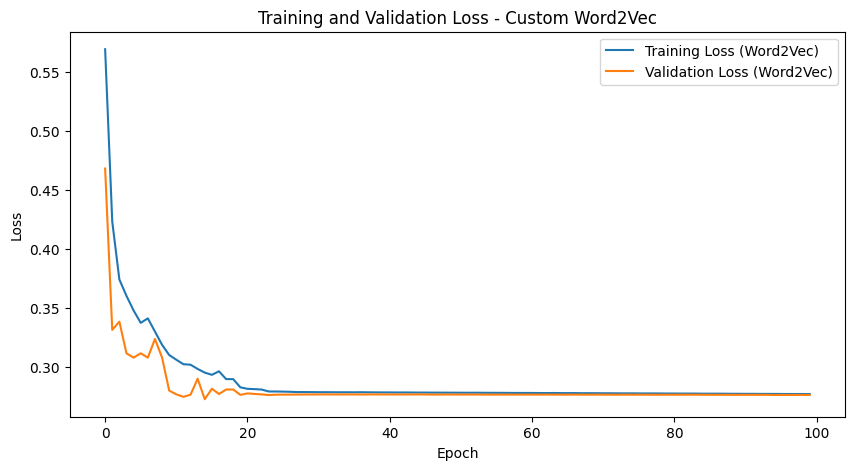

In [52]:
# Plot losses for Custom Word2Vec
plt.figure(figsize=(10, 5))
plt.plot(history_w2v.history['loss'], label='Training Loss (Word2Vec)')
plt.plot(history_w2v.history['val_loss'], label='Validation Loss (Word2Vec)')
plt.title('Training and Validation Loss - Custom Word2Vec')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 2s 111ms/step

--- Custom Word2Vec: Classification Report ---
              precision    recall  f1-score   support

    Negative       0.67      0.72      0.69       114
    Positive       0.92      0.90      0.91       391

    accuracy                           0.86       505
   macro avg       0.79      0.81      0.80       505
weighted avg       0.86      0.86      0.86       505



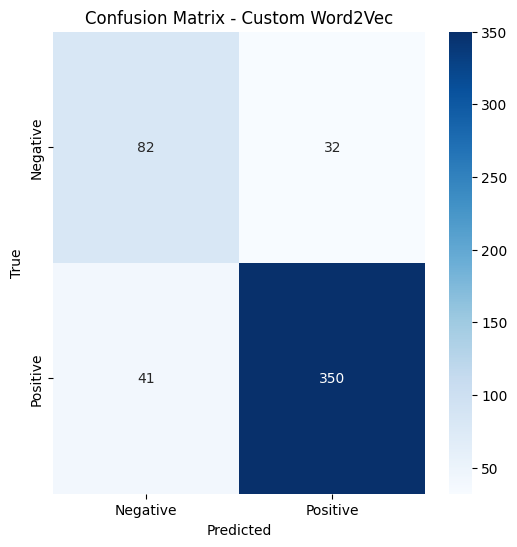

In [53]:
# Inference and evaluation for Custom Word2Vec
y_pred_w2v = (model_w2v.predict(X_test) > 0.5).astype(int)
print("\n--- Custom Word2Vec: Classification Report ---")
print(classification_report(y_test, y_pred_w2v, target_names=['Negative', 'Positive']))

# Confusion Matrix for Word2Vec
cm_w2v = confusion_matrix(y_test, y_pred_w2v)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Custom Word2Vec')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**From my experiments done it seems that a complex architecture would make the model overfit to the class with not enough volume and variety which is the Poor sentiment class although the simple lstm model have helped improved the the recall and f1score of this class there seem to still be a gap in understanding complex relationship about this class due to lck of volume and variety in conclusion one of the first appraoch in helping improve these models I tried using lstm and all of it other forms would be to first get equal amount of data for both classes and the retry the models that gave the best results in the experiment**

**@Team anyone can try this glove embedding layers using the hyperparameter in this google spread sheets https://docs.google.com/spreadsheets/d/1YLojFlst-nGRykdGIQNkC7_fWPJjrQI9AVLKZh4nTvY/edit?usp=sharing it contain the hyper parameters I tried using the custom word2vec embedding and also the traditional methods, but remmber to change the architecture of the *CREATE LSTM FUNCTION* based on the hyperparameters in a each experiment**

In [ ]:
# Create, Compile, Train, and Evaluate LSTM with Pre-Trained GloVe
# Create model
model_glove = create_lstm_model(
    embedding_matrix=embedding_matrix_glove,
    max_words=max_words, max_len=max_len, embedding_dim=embedding_dim,
    lstm_units=64, dense_units=32, trainable_embedding=False
)

# Compile model
optimizer = Adam(learning_rate=0.001)
model_glove.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train model
history_glove = model_glove.fit(
    X_train, y_train, epochs=10, batch_size=32, validation_split=0.2,
    callbacks=[early_stopping, reduce_lr], verbose=1
)

# Evaluate model
y_pred_glove = (model_glove.predict(X_test) > 0.5).astype(int)
print("\n--- LSTM with Pre-Trained GloVe Embedding ---")
print("Accuracy:", accuracy_score(y_test, y_pred_glove))
print("Classification Report:")
print(classification_report(y_test, y_pred_glove, target_names=['Bad', 'Good']))

# Save model
model_glove.save('lstm_glove.h5')

print("LSTM with Pre-Trained GloVe trained and evaluated! Model saved as lstm_glove.h5")

In [ ]:
# Plot losses for GloVe
plt.figure(figsize=(10, 5))
plt.plot(history_glove.history['loss'], label='Training Loss (GloVe)')
plt.plot(history_glove.history['val_loss'], label='Validation Loss (GloVe)')
plt.title('Training and Validation Loss - GloVe')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Inference and evaluation for GloVe
y_pred_glove = (model_glove.predict(X_test) > 0.5).astype(int)
print("\n--- GloVe: Classification Report ---")
print(classification_report(y_test, y_pred_glove, target_names=['Negative', 'Positive']))

# Confusion Matrix for GloVe
cm_glove = confusion_matrix(y_pred_glove, y_test)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - GloVe')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()